# Using the Custom Hardware Image Generator

This notebook demonstrates hardware generation of an image stream and displaying it on the HDMI output. Before running it you will need to compile the example overlay with the frame generator in Verilog. Two files are generated:
- a `.bit` file, containing the FPGA configuration bitstream
- a `.hwh` (hardware handoff) file, containing information about the module heirarchy and memory map

Copy both files to the user home directory on the Pynq operating system. Then load them (loading the `.bit` also reads the `.hwh` of the same name):

In [3]:
from pynq import Overlay
from pynq.lib.video import *

overlay = Overlay("/home/xilinx/elec50015.bit")

The overlay object is automatically configured with a Python attribute structure that allows you to access the hardware as Python objects. Appropriate driver classes are instantiated where a hardware block is recognised by the Pynq library. Here we get a convenient handle to the VDMA connected to the image generator:

In [4]:
imgen_vdma = overlay.video.axi_vdma_0.readchannel

Next, the image generator DMA is configured and started:

In [5]:
videoMode = common.VideoMode(640, 480, 24)
imgen_vdma.mode = videoMode
imgen_vdma.start()

The VDMA continuously reads frames into a cycle of memory buffers. You can take software ownership of a frame and get a NumPy handle for it:

In [6]:
frame = imgen_vdma.readframe()

The frame can be displayed in the notebook using PiL:

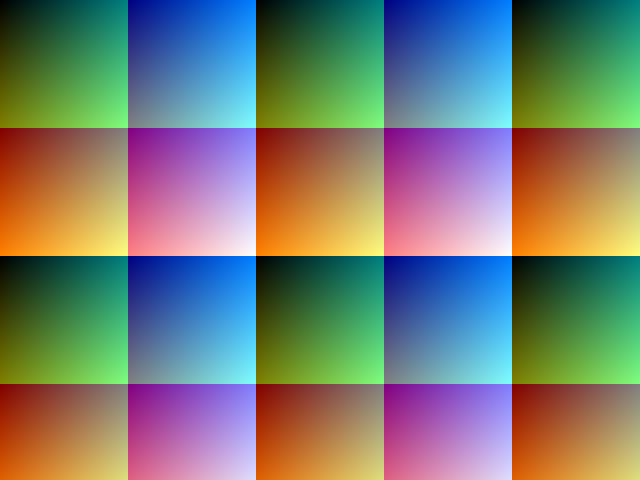

In [7]:
import PIL.Image

image = PIL.Image.fromarray(frame)
image

The HDMI output is handled with a wrapper object that configures both the VDMA and the HDMI output generator.

A bit of hacking is needed here: the image generator and its VDMA are in the same part of the design hierarchy (`video`) as the HDMI interface. The HDMI output wrapper `overlay.video.hdmi_out` picks up the image generator VDMA, not the one connected to HDMI, so that attribute needs to be changed to point to the correct VDMA.

After that, the HDMI output is configured and started:

In [8]:
hdmi_out = overlay.video.hdmi_out
hdmi_out._vdma = overlay.video.axi_vdma #Use the correct VDMA!
hdmi_out.configure(videoMode)
hdmi_out.start()

Now our frame can be sent to the HDMI output. At this stage ownership of the frame is transferred to the hardware, so it's no longer accessible to Python code. Connect a display to the HDMI port and you should see it.

In [9]:
hdmi_out.writeframe(frame)

Finally, stop the VDMAs so that the system is in a stable state at the end of the notebook

In [10]:
imgen_vdma.stop()
hdmi_out.close()

Todo:
- [ ] Copy multiple frames and find frame rate
- [ ] Link input and output for continuous video output without software control
- [ ] Change image generator settings with MMIO